<div class="alert alert-block alert-warning">

<h1>Coronavirus Tweets NLP - Text Classification</h1>
    
<a href="https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification">Kaggle Link</a>


</div>

<hr>

<div class="alert alert-block alert-info">
    <h2>Columns</h2>
    <p><strong>Tweet:</strong> Twitter Text.</p>
    <p><strong>Sentiment:</strong> Label</p>
</div>

## Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

import re

In [2]:
from wordcloud import WordCloud,STOPWORDS

In [3]:
# to expand the text
import contractions

# to auto correct the words
from autocorrect import Speller

# for handling accented characters
from unidecode import unidecode

# to get list of punctiations
from string import punctuation

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

In [5]:
nltk.download('stopwords')

all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
all_stopwords.remove('nor')
all_stopwords.remove('no')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer

In [7]:
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

In [8]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix
from lime.lime_text import LimeTextExplainer

from sklearn.pipeline import make_pipeline

## Dataset

In [9]:
train = pd.read_csv('Corona_NLP_train.csv',encoding = 'latin1')
test = pd.read_csv('Corona_NLP_test.csv')

df = train.copy()

In [10]:
df.columns = map(str.lower,df.columns)
df = df[['originaltweet','sentiment']]
df.columns = ['tweet','label']

In [11]:
df.head()

tweet               label
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1  advice Talk to your neighbours family to excha...            Positive
2  Coronavirus Australia: Woolworths to give elde...            Positive
3  My food stock is not the only one which is emp...            Positive
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

## E.D.A

In [12]:
df.isnull().sum()

tweet    0
label    0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   41157 non-null  object
 1   label   41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


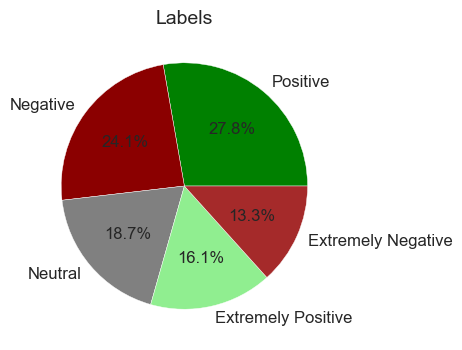

In [14]:
plt.figure(figsize = (6,4))
df['label'].value_counts().plot.pie(
    autopct = '%.1f%%',
    textprops = {'size':12},
    colors = ['green','darkred','gray','lightgreen','brown']
)
plt.title('Labels',size = 14)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [15]:
df['label'] = df['label'].replace('Extremely Positive','Positive').replace('Extremely Negative','Negative')
test['Sentiment'] = test['Sentiment'].replace('Extremely Positive','Positive').replace('Extremely Negative','Negative')

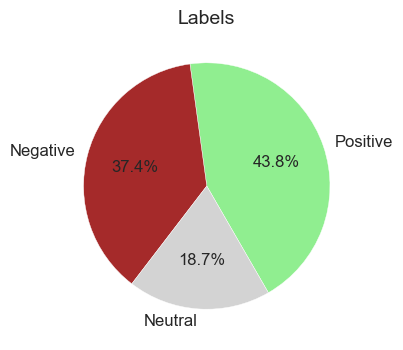

In [16]:
plt.figure(figsize = (6,4))
df['label'].value_counts().plot.pie(
    autopct = '%.1f%%',
    textprops = {'size':12},
    colors = ['lightgreen','brown','lightgray'],
    startangle = 300
)
plt.title('Labels',size = 14)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [17]:
df['tweet_len'] = df['tweet'].apply(len)

In [18]:
def plot_hist(data,col):
    plt.figure(figsize = (15,6))
    labels = ['Positive','Negative','Neutral']
    for j,i in enumerate(labels,start = 1):  
        plt.subplot(2,3,j)
        sns.histplot(x = col,data = df[df['label'] == i])
        plt.xticks(np.arange(0,310,50))
        plt.yticks(np.arange(0,1750,250))
        plt.title(i)
        
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

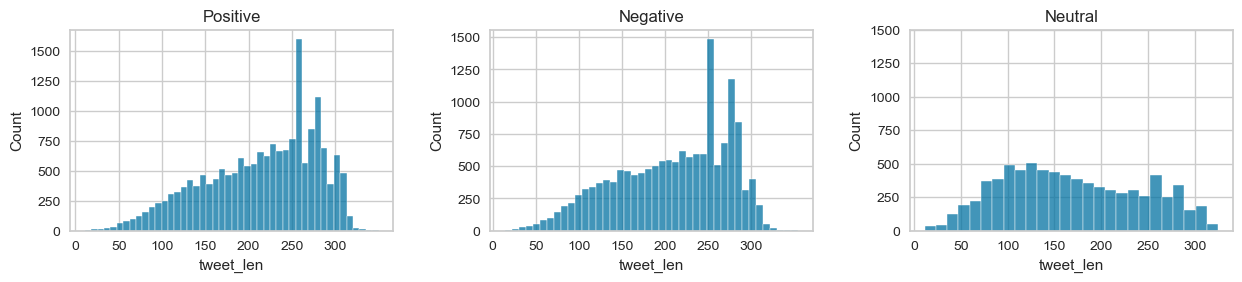

In [19]:
plot_hist(df,'tweet_len')

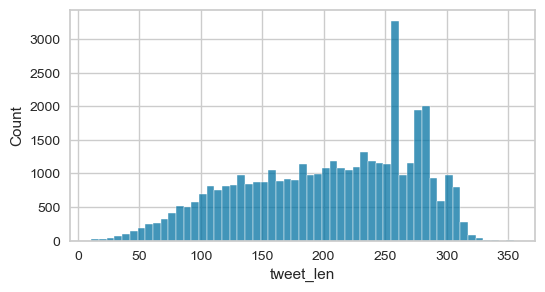

In [20]:
plt.figure(figsize = (6,3))
sns.histplot(x = 'tweet_len',data = df)
plt.show()

In [21]:
def plot_wordcloud(text,label):
    
    cloud = WordCloud(
        stopwords=STOPWORDS,
        height=1000,
        width = 1500,
        background_color='white'
    ).generate(' '.join(text))
    
    
    plt.figure(figsize = (6,6))
    plt.imshow(cloud)
    plt.title(label,size = 14, y = 1.05)
    plt.axis('off')
    plt.show()

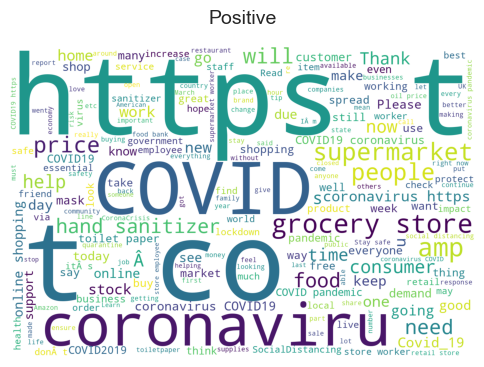

In [22]:
plot_wordcloud(df[df['label'] == 'Positive']['tweet'], 'Positive')

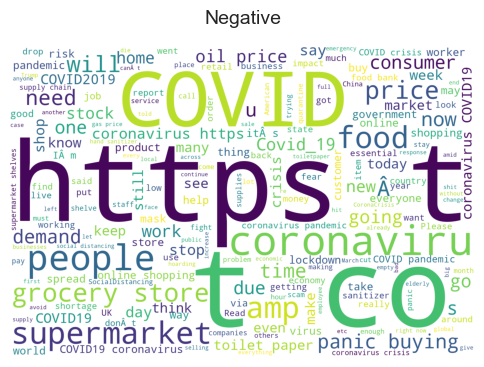

In [23]:
plot_wordcloud(df[df['label'] == 'Negative']['tweet'], 'Negative')

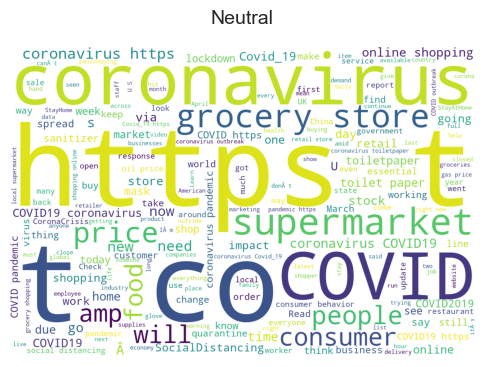

In [24]:
plot_wordcloud(df[df['label'] == 'Neutral']['tweet'], 'Neutral')

In [25]:
def most_frequent_words(text_list,n = 10,x = 1):
    vectorizer = CountVectorizer(ngram_range=(x,x))
    docs = vectorizer.fit_transform(text_list)
    features = vectorizer.get_feature_names_out()
    
    plt.figure(figsize = (8,4))
    visualizer = FreqDistVisualizer(features=features,n=n,orient='h')
    visualizer.fit(docs)
    visualizer.show()

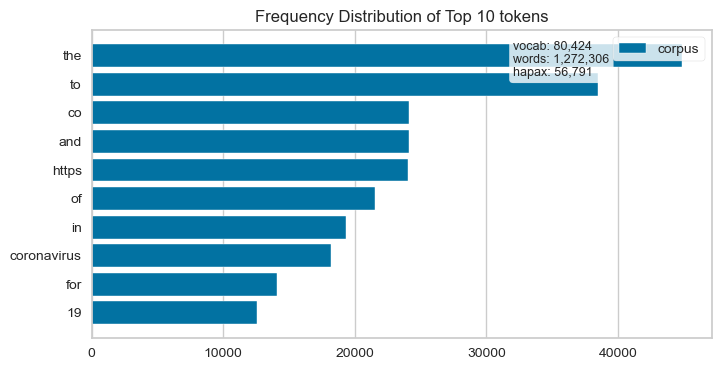

In [26]:
most_frequent_words(df['tweet'])

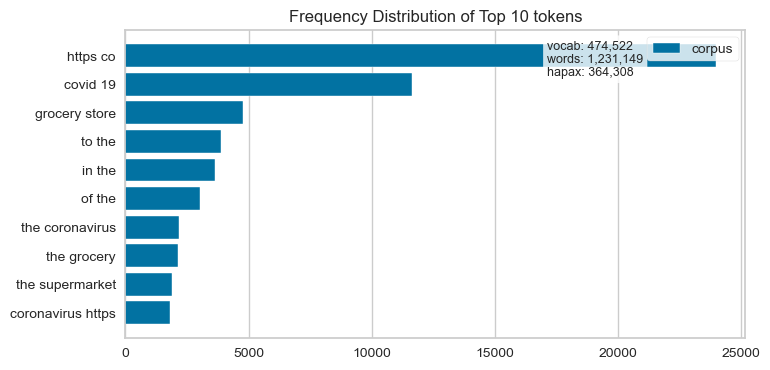

In [27]:
most_frequent_words(df['tweet'],x = 2)

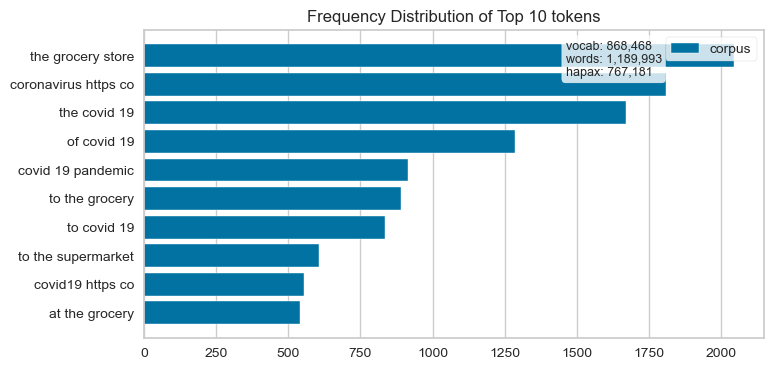

In [28]:
most_frequent_words(df['tweet'],x = 3)

## Text Preprocessing

### 1. Remove Mentions, Hashtags and Links From Tweets 

In [29]:
def remove_hasthtag_mention_link(text):
    clean_text = re.sub("@[A-Za-z0-9_]+","", text)
    clean_text = re.sub("#[A-Za-z0-9_]+","", clean_text)
    clean_text = re.sub(r'http\S+', '', clean_text)
    clean_text = re.sub(r'www\S+', '', clean_text)
    clean_text = re.sub(r'pic.twitter.com\S+', '', clean_text)
    clean_text = re.sub(r't\.co\S+', '', clean_text)
    
    clean_text = " ".join(clean_text.strip().split())
    return clean_text

### 2. Remove Spaces

In [30]:
def remove_spaces(text):
    clean_text = text.replace('\\n',' ').replace('\t',' ').replace('\\',' ')
    return clean_text

### 3. Expanding Text

In [31]:
def expand_text(text):
    ex_text = contractions.fix(text)
    return ex_text

### 4. Handling Accented Characters

In [32]:
def handling_accented(text):
    return unidecode(text)

### 5. Cleaning Text

In [33]:
def text_cleaning(text):
    token = word_tokenize(text)
    clean_text = [i.lower() for i in token if (i not in punctuation) and (i.lower() not in all_stopwords) and (i.isalpha()) and (len(i) > 2)]
    return clean_text

### 6. Text Auto Correction

In [34]:
def auto_correct(text):
    spell = Speller(lang='en')
    return spell(text)

### 7. Getting Root of the Words

In [35]:
def lemmatization(text):
    lem = WordNetLemmatizer()
    lst = []
    for i in text:
        lem_words = lem.lemmatize(i)
        lst.append(lem_words)
        
    return ' '.join(lst)

### 8. Apply Preprocessing

In [36]:
def text_preprocessing(data):
    data['cleaned_tweet'] = data['tweet'].apply(remove_hasthtag_mention_link)
    data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_spaces)
    data['cleaned_tweet'] = data['cleaned_tweet'].apply(expand_text)
    data['cleaned_tweet'] = data['cleaned_tweet'].apply(handling_accented)
    data['cleaned_tweet'] = data['cleaned_tweet'].apply(text_cleaning)
    data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x: auto_correct(x) if isinstance(x,str) or isinstance(x, bytes) else x)
    data['cleaned_tweet'] = data['cleaned_tweet'].apply(lemmatization)
    
    return data

In [37]:
%%time
df = text_preprocessing(df.copy())

CPU times: total: 12.2 s
Wall time: 12.9 s


In [38]:
print(f"Total empty tweets: {len(df[df['cleaned_tweet'] == ''])}")

Total empty tweets: 59


### Remove Empty Tweets

In [39]:
df = df[df['cleaned_tweet'] != '']
df = df.reset_index().drop('index',axis = 1)

## E.D.A Continue

In [40]:
df['cleaned_tweet_len'] = df['cleaned_tweet'].apply(len)

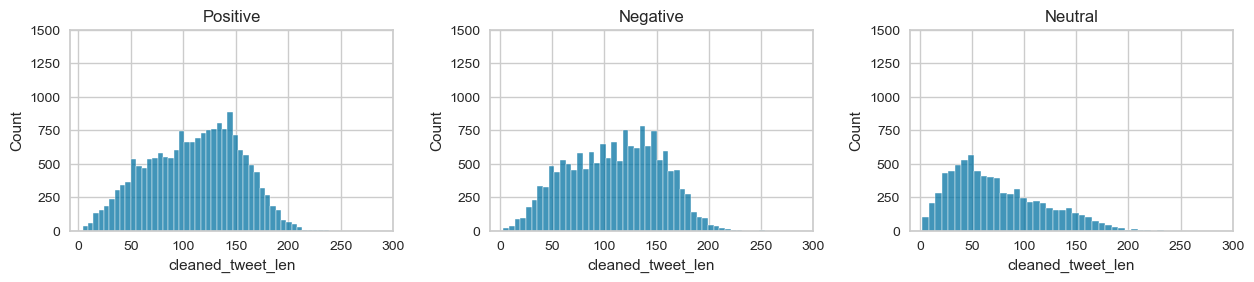

In [41]:
plot_hist(df,'cleaned_tweet_len')

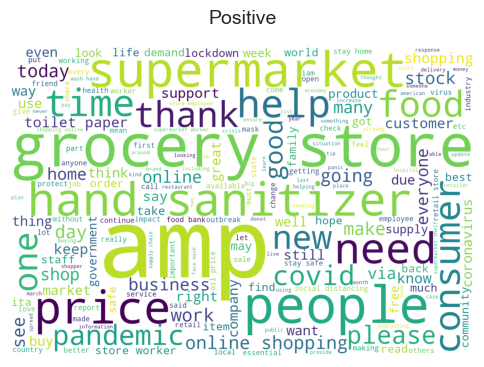

In [42]:
plot_wordcloud(df[df['label'] == 'Positive']['cleaned_tweet'], 'Positive')

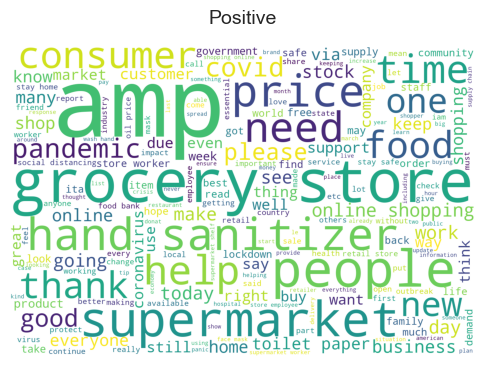

In [43]:
plot_wordcloud(df[df['label'] == 'Positive']['cleaned_tweet'], 'Positive')

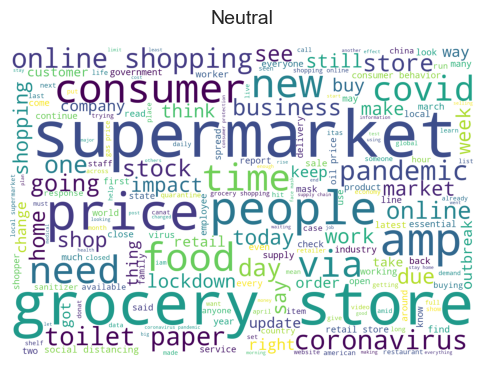

In [44]:
plot_wordcloud(df[df['label'] == 'Neutral']['cleaned_tweet'], 'Neutral')

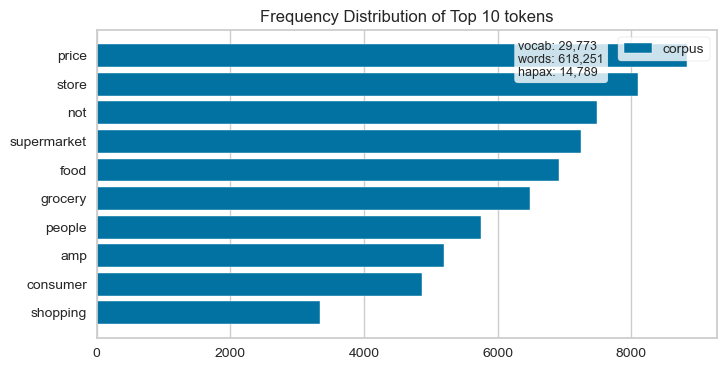

In [45]:
most_frequent_words(df['cleaned_tweet'])

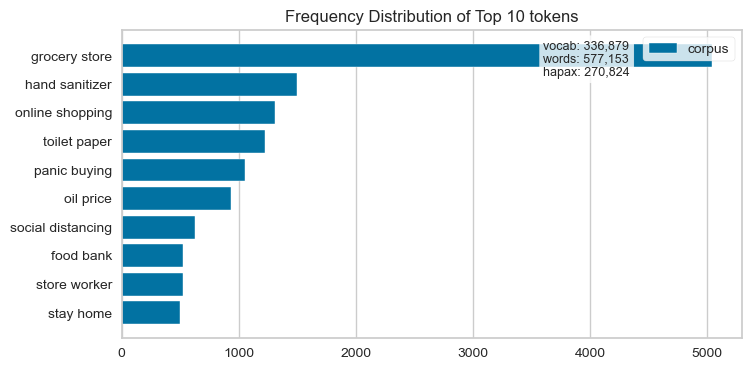

In [46]:
most_frequent_words(df['cleaned_tweet'], x = 2)

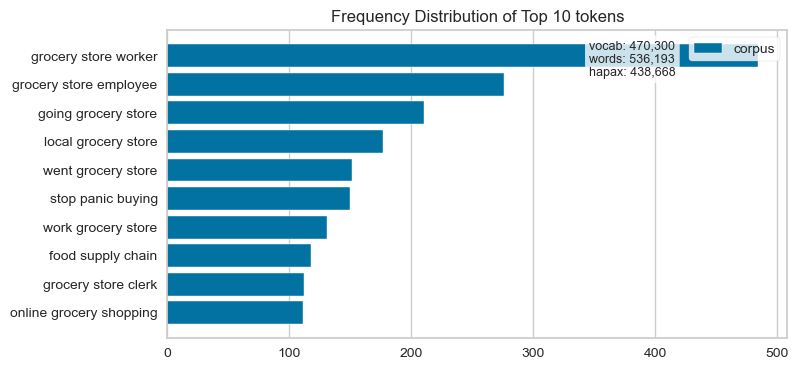

In [47]:
most_frequent_words(df['cleaned_tweet'], x = 3)

## Creating Train and Test Sets

In [48]:
X_train = df['cleaned_tweet']
y_train = df['label']

In [49]:
X_test = test['OriginalTweet']
y_test = test['Sentiment']

## TF-IDF Vectorizer

In [50]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Oversample

In [51]:
smote = SMOTE()

X_train_vec_smote,y_train_smote = smote.fit_resample(X_train_vec,y_train)

In [52]:
print('Before'.center(20,'_'))
y_train.value_counts()

_______Before_______


Positive    18042
Negative    15395
Neutral      7661
Name: label, dtype: int64

In [53]:
print('After'.center(20,'_'))
y_train_smote.value_counts()

_______After________


Positive    18042
Negative    18042
Neutral     18042
Name: label, dtype: int64

## Logistic Regression Model

In [54]:
%%time
lr = LogisticRegression(max_iter=1000)
lr_model = lr.fit(X_train_vec_smote,y_train_smote)

CPU times: total: 34.4 s
Wall time: 8 s


In [55]:
y_pred = lr_model.predict(X_test_vec)

In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.76      0.78      0.77      1633
     Neutral       0.53      0.74      0.62       619
    Positive       0.85      0.69      0.76      1546

    accuracy                           0.73      3798
   macro avg       0.71      0.73      0.71      3798
weighted avg       0.76      0.73      0.74      3798



In [57]:
%%time
cvs = cross_val_score(estimator=lr,X=X_train_vec_smote,y=y_train_smote,cv = 10)

CPU times: total: 5min 22s
Wall time: 1min 10s


In [58]:
print(f'Cross Validation Score: {round(cvs.mean(),2)}')

Cross Validation Score: 0.83


In [59]:
def plot_confusion_matrix(percent = False):
    plt.figure(figsize = (4,4))
    visualizer = ConfusionMatrix(lr_model,percent = percent)
    visualizer.class_counts_ = 3
    visualizer.score(X_test_vec,y_test)
    visualizer.show()
    plt.show()

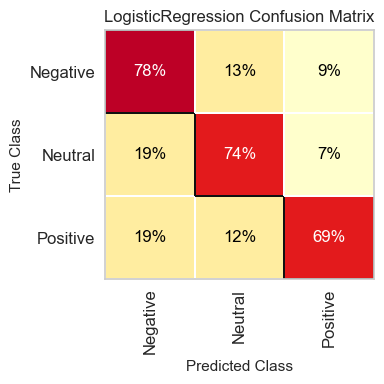

In [60]:
plot_confusion_matrix(percent=True)

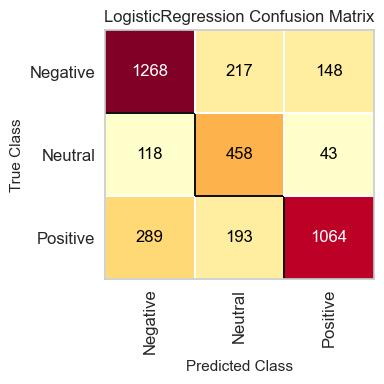

In [61]:
plot_confusion_matrix()

## Predict a Single Value

In [62]:
c = make_pipeline(vectorizer,lr_model)

explainer = LimeTextExplainer(class_names=lr_model.classes_)

In [63]:
def clean_entered_text(text):
    text = remove_hasthtag_mention_link(text)
    text = remove_spaces(text)
    text = expand_text(text)
    text = handling_accented(text)
    text = text_cleaning(text)
    text = auto_correct[text] if (isinstance(text,str) or (isinstance(text,bytes))) else text
    text = lemmatization(text)
    
    return text

In [64]:
text = input("Enter a text:\n-> ")
text = clean_entered_text(text)
print('\n')
if text != "":
    exp = explainer.explain_instance(text, c.predict_proba, labels=[0,1,2])
    exp.show_in_notebook()
    
else:
    print("Invalid text!")

Enter a text:
-> A total of 6,861,784 people lost their lives due to COVID 19.


